In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE, ADASYN

ModuleNotFoundError: No module named 'sklearn'

### 0. Load Dataset

In [ ]:
# mount google drive
drive.mount('/content/drive', force_remount=True)

PATH = "/content/drive/MyDrive/flight_total.csv"
!ls {PATH}

Mounted at /content/drive
/content/drive/MyDrive/flight_total.csv


In [ ]:
data = pd.read_csv(PATH)

In [ ]:
data.head()

,FL_DATE,OP_CARRIER,ORIGIN_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,FLIGHT_DELAY_LEVEL
0,01/01/2018,AA,Chicago,500,455.0,-5.0,0
1,01/01/2018,AA,Chicago,515,509.0,-6.0,0
2,01/01/2018,AA,Chicago,529,527.0,-2.0,0
3,01/01/2018,AA,Chicago,630,625.0,-5.0,0
4,01/01/2018,AA,Chicago,703,658.0,-5.0,0


- FL_DATE format conversion : An error occurred while loading the pre-processed dataset in Colab, due to the FL_DATE format being inconsistent. Here is the code to address this issue.

In [ ]:
data['FL_DATE'] = pd.to_datetime(data['FL_DATE'], format='%d/%m/%Y', errors='coerce').fillna(pd.to_datetime(data['FL_DATE'], format='%Y-%m-%d', errors='coerce'))

print(data['FL_DATE'])

0         2018-01-01
1         2018-01-01
2         2018-01-01
3         2018-01-01
4         2018-01-01
             ...    
3678854   2023-12-31
3678855   2023-12-31
3678856   2023-12-31
3678857   2023-12-31
3678858   2023-12-31
Name: FL_DATE, Length: 3678859, dtype: datetime64[ns]


In [ ]:
# Convert the FL_DATE column to integer for usage
data['FL_DATE'] = data['FL_DATE'].dt.strftime('%Y%m%d').astype(int)

# Categorical variable encoding
df_encoded = pd.get_dummies(data[['OP_CARRIER', 'ORIGIN_CITY_NAME']])

### 1. Decision Trees modeling (without parameter tuning)

In [ ]:
X = data[['CRS_DEP_TIME', 'FL_DATE']].join(df_encoded)
y = data['FLIGHT_DELAY_LEVEL']

# Splitting data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = DecisionTreeClassifier(random_state=0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluating model performance
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:")
print(report)

Accuracy: 0.730421924183035
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.90      0.86    578459
           1       0.22      0.15      0.18     86982
           2       0.10      0.06      0.07     30631
           3       0.06      0.03      0.04     15170
           4       0.04      0.02      0.03      8555
           5       0.12      0.06      0.08     15975

    accuracy                           0.73    735772
   macro avg       0.22      0.20      0.21    735772
weighted avg       0.67      0.73      0.70    735772



In [ ]:
# Model performance evaluation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.730421924183035
Precision: 0.6742919081861491
Recall: 0.730421924183035
F1 Score: 0.6991760968165579


### 2. Search for the best parameter combinations

In [ ]:
model = DecisionTreeClassifier()

# Define the hyperparameter grid to search
param_grid = {
    'max_depth': [5, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_leaf_nodes': [100, 200, 300, 400, 500]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

# Train the model using GridSearchCV
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'max_depth': 20, 'max_leaf_nodes': 500, 'min_samples_leaf': 1, 'min_samples_split': 2}


### 3. Apply the best parameters to the model.

In [ ]:
X = data[['CRS_DEP_TIME', 'FL_DATE']].join(df_encoded)
y = data['FLIGHT_DELAY_LEVEL']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = DecisionTreeClassifier(criterion='gini', max_depth=20, min_samples_split=2, min_samples_leaf=1, max_leaf_nodes=500, random_state=0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Model performance evaluation
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:")
print(report)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.7870101063916539
Classification Report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88    578459
           1       0.37      0.02      0.05     86982
           2       0.00      0.00      0.00     30631
           3       0.00      0.00      0.00     15170
           4       0.00      0.00      0.00      8555
           5       0.42      0.01      0.01     15975

    accuracy                           0.79    735772
   macro avg       0.26      0.17      0.16    735772
weighted avg       0.67      0.79      0.70    735772



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Model performance evaluation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

### 4. Feature Importance Exploration

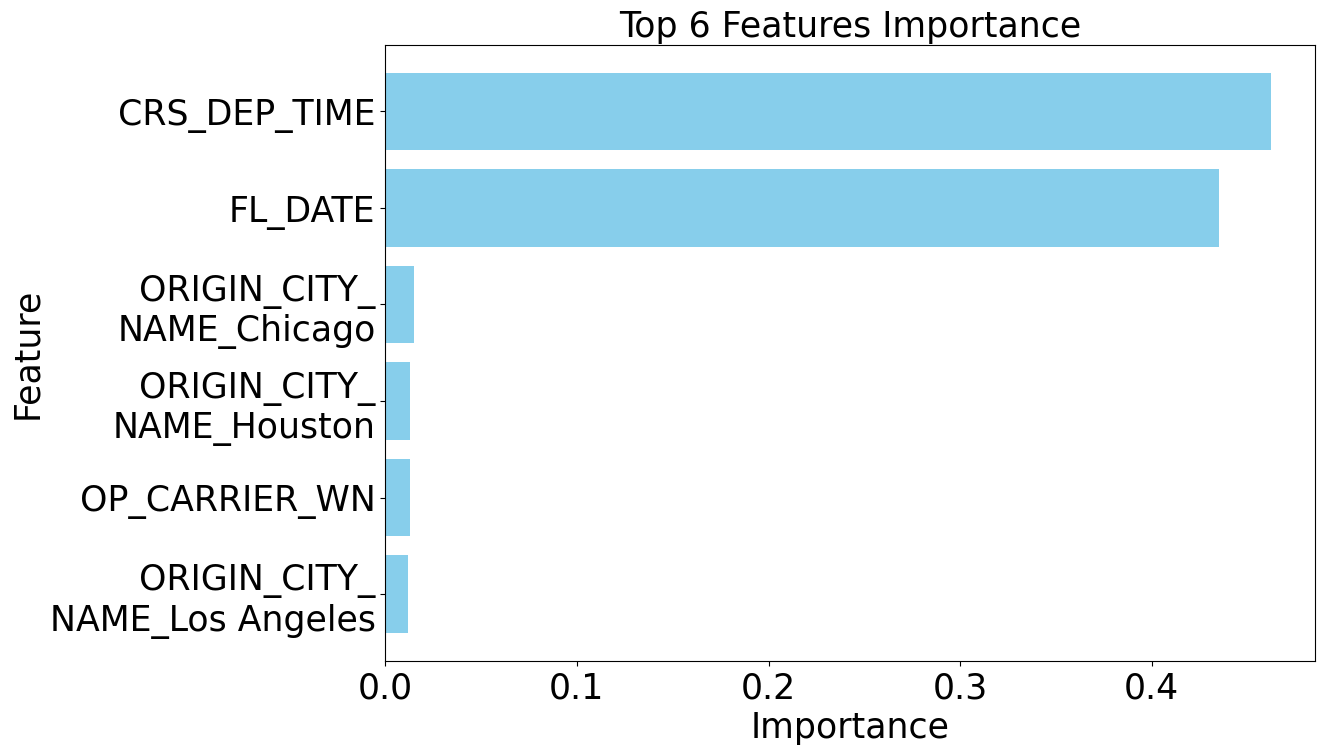

In [ ]:
feature_importances = model.feature_importances_
feature_names = X_train.columns

# Sorting by importance
sorted_idx = feature_importances.argsort()[::-1]
top_features = feature_names[sorted_idx][:6]
top_importances = feature_importances[sorted_idx][:6]

# Plotting the graph
plt.figure(figsize=(12, 8))
bars = plt.barh(top_features, top_importances, color='skyblue')

plt.xlabel('Importance', fontsize=25)
plt.ylabel('Feature', fontsize=25)
plt.title('Top 6 Features Importance', fontsize=25)
plt.gca().invert_yaxis()

plt.xticks(fontsize=25)
plt.yticks(top_features, [f'{name[:12]}\n{name[12:]}' if len(name) > 15 else name for name in top_features], fontsize=25)

plt.show()


### Weighting => Performance Degradation

In [ ]:
X = data[['CRS_DEP_TIME', 'FL_DATE']].join(df_encoded)
y = data['FLIGHT_DELAY_LEVEL']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

class_weights = {0: 1/0.786053, 1: 1/0.118597, 2: 1/0.041518, 3: 1/0.020619, 4: 1/0.011671, 5: 1/0.021541}

model = DecisionTreeClassifier(criterion='gini', max_depth=20, min_samples_split=2, min_samples_leaf=1, max_leaf_nodes=500, random_state=0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:")
print(report)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.45926999124728857
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.53      0.66    578459
           1       0.21      0.26      0.23     86982
           2       0.12      0.07      0.09     30631
           3       0.00      0.00      0.00     15170
           4       0.03      0.06      0.04      8555
           5       0.03      0.49      0.06     15975

    accuracy                           0.46    735772
   macro avg       0.21      0.23      0.18    735772
weighted avg       0.71      0.46      0.55    735772



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Over sampling

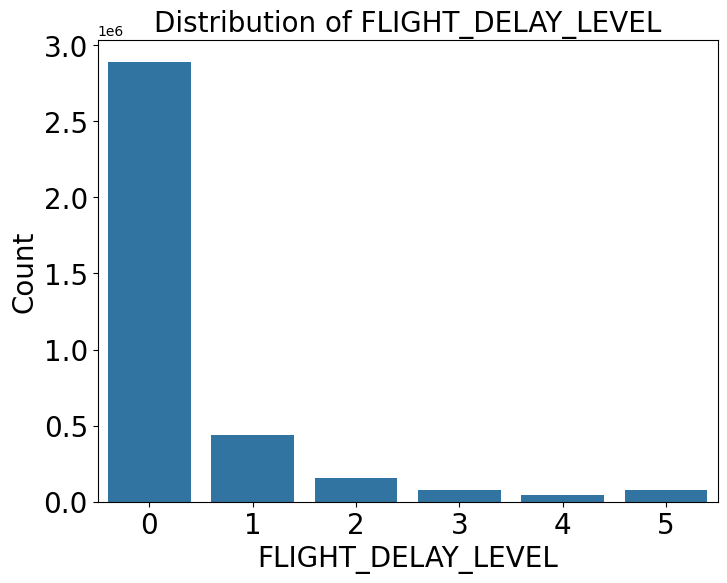

In [ ]:
# Visualization of the distribution of FLIGHT_DELAY_LEVEL
plt.figure(figsize=(8, 6))
sns.countplot(x='FLIGHT_DELAY_LEVEL', data=data)
plt.title('Distribution of FLIGHT_DELAY_LEVEL', fontsize=20)
plt.xlabel('FLIGHT_DELAY_LEVEL', fontsize=20)
plt.ylabel('Count', fontsize=20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()

In [ ]:
X = data[['CRS_DEP_TIME', 'FL_DATE']].join(df_encoded)
y = data['FLIGHT_DELAY_LEVEL']

# Splitting the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Performing oversampling using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

model = DecisionTreeClassifier(criterion='gini', max_depth=20, min_samples_split=2, min_samples_leaf=1, max_leaf_nodes=500, random_state=0)
model.fit(X_resampled, y_resampled)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:")
print(report)


Accuracy: 0.7386771989148813
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.91      0.86    578459
           1       0.27      0.18      0.21     86982
           2       0.15      0.02      0.03     30631
           3       0.05      0.01      0.01     15170
           4       0.03      0.02      0.02      8555
           5       0.07      0.12      0.09     15975

    accuracy                           0.74    735772
   macro avg       0.23      0.21      0.20    735772
weighted avg       0.68      0.74      0.71    735772



In [1]:
X = data[['CRS_DEP_TIME', 'FL_DATE']].join(df_encoded)
y = data['FLIGHT_DELAY_LEVEL']

# Splitting the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Performing oversampling using ADASYN
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)

model = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_split=10, min_samples_leaf=4, max_leaf_nodes=450, random_state=0)
model.fit(X_resampled, y_resampled)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:")
print(report)


NameError: name 'data' is not defined

: 